In [1]:
"""
The Inter-Chain compactness factor (CCR) Analysis Script for Submission

Author: Qin Zhang
Created: 2025-06-11
Last Modified: 2025-06-11
License: MIT License

This script analyzes inter-chain compactness factor (CCR) in RNA systems under varying salt concentrations.
"""
# %% Cell 1: Data Paths and System Configurations
import numpy as np
import MDAnalysis as mda
from scipy.spatial import cKDTree
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
"""
Define file paths for MD simulation trajectories of RNA systems with different
repeat lengths (3x, 5x, 8x G4C2) and salt conditions.
Data source: Zenodo repository (DOI: 10.5281/zenodo.15608685)
"""
conditions_3x = {
    "neutral":   "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_Na_neutral/lake_10us/",
    "17mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_17mMNaCl_10mMMgCl2/lake_10us/",
    "35mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_35mMNaCl_21mMMgCl2/lake_10us/",
    "70mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_70mMNaCl_42mMMgCl2/lake_10us/",
    "139mMNaCl": "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_139mMNaCl_83mMMgCl2/lake_10us/",
    "278mMNaCl": "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_278mMNaCl_167mMMgCl2/lake_10us/",
    "487mMNaCl": "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_487mMNaCl_292mMMgCl2/lake_10us/",
    "696mMNaCl": "/media/qzhang04/3xG4C2/zenodo/A_3xG4C2_800uM_12_696mMNaCl_417mMMgCl2/lake_10us/"
}
conditions_5x = {
    "neutral":   "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_Na_neutral/lake_10us/",
    "17mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_17mMNaCl_10mMMgCl2/lake_10us/",
    "35mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_35mMNaCl_21mMMgCl2/lake_10us/",
    "70mMNaCl":  "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_70mMNaCl_42mMMgCl2/lake_10us/",
    "139mMNaCl": "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_139mMNaCl_83mMMgCl2/lake_10us/",
    "278mMNaCl": "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_278mMNaCl_167mMMgCl2/lake_10us/",
    "487mMNaCl": "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_487mMNaCl_292mMMgCl2/lake_10us/",
    "696mMNaCl": "/media/qzhang04/3xG4C2/zenodo/B_5xG4C2_800uM_12_696mMNaCl_417mMMgCl2/lake_10us/"
}
conditions_8x = {
    "487mMNaCl": "/media/qzhang04/3xG4C2/zenodo/C_8xG4C2_800uM_12_487mMNaCl_292mMMgCl2/lake_10us/"}
"""
Define chain index ranges for different RNA systems.
Each chain corresponds to a specific segment of the RNA molecule.
"""
chains_3x = { 
    "ch1": 'index 0 to 215',
    "ch2": 'index 216 to 431',
    "ch3": 'index 432 to 647',
    "ch4": 'index 648 to 863',
    "ch5": 'index 864 to 1079',
    "ch6": 'index 1080 to 1295',
    "ch7": 'index 1296 to 1511',
    "ch8": 'index 1512 to 1727',
    "ch9": 'index 1728 to 1943',
    "ch10": 'index 1944 to 2159',
    "ch11": 'index 2160 to 2375',
    "ch12": 'index 2376 to 2591'
}
chains_5x = {
    "ch1": 'index 0 to 359',
    "ch2": 'index 360 to 719',
    "ch3": 'index 720 to 1079', 
    "ch4": 'index 1080 to 1439',
    "ch5": 'index 1440 to 1799',
    "ch6": 'index 1800 to 2159',
    "ch7": 'index 2160 to 2519',
    "ch8": 'index 2520 to 2879',
    "ch9": 'index 2880 to 3239',
    "ch10": 'index 3240 to 3599',
    "ch11": 'index 3600 to 3959',
    "ch12": 'index 3960 to 4319'
}
chains_8x = {
    "ch1": 'index 0 to 575',
    "ch2": 'index 576 to 1151',
    "ch3": 'index 1152 to 1727',
    "ch4": 'index 1728 to 2303',
    "ch5": 'index 2304 to 2879',
    "ch6": 'index 2880 to 3455',
    "ch7": 'index 3456 to 4031',
    "ch8": 'index 4032 to 4607',
    "ch9": 'index 4608 to 5183',
    "ch10": 'index 5184 to 5759',
    "ch11": 'index 5760 to 6335',
    "ch12": 'index 6336 to 6911'
}
stride = 25   #frame sampling

In [2]:
# %% Cell 2: Core Functions for Inter-Chain CCR
def calculate_inter_chain_ccr(positions, bead_diameter=0):
    """
    Compute inter-chain compactness factor (CCR) for RNA systems.
    
    Parameters:
        positions (list of arrays): Coordinates of 'BB' beads for each chain
        bead_diameter (float): Bead diameter (Å) for distance correction
        
    Returns:
        float: Inter-chain CCR value, calculated as Σ[1/(1+d²)]
               where d is the corrected inter-chain bead distance
    """
    all_beads = np.concatenate(positions)
    n_beads = len(all_beads)
    
    # Create chain membership array
    chain_ids = []
    for i, chain in enumerate(positions):
        chain_ids.extend([i] * len(chain))
    chain_ids = np.array(chain_ids)

    # Efficiently compute distance matrix using KD-tree
    tree = cKDTree(all_beads)
    dist_matrix = tree.sparse_distance_matrix(tree, max_distance=520, output_type='coo_matrix')
    
    
    # Calculate contributions only from inter-chain contacts
    ccr_sum = 0.0
    for i, j, d in zip(dist_matrix.row, dist_matrix.col, dist_matrix.data):
        if i < j and chain_ids[i] != chain_ids[j]:
            adjusted_d = max(0, d - bead_diameter)
            ccr_sum += 1 / (1 + adjusted_d ** 2)
    return ccr_sum

def analyze_replica_ccr(gro_file, xtc_file, chains, stride, bead_diameter=0):
    """
    Analyze inter-chain CCR time series for a single simulation replica.
    
    Parameters:
        gro_file (str): Path to initial structure file
        xtc_file (str): Path to trajectory file
        chains (dict): Chain index configuration dictionary
        stride (int): Trajectory frame sampling interval
        bead_diameter (float): Bead diameter (Å)
        
    Returns:
        tuple: (Time series in μs, CCR value series)
    """
    u = mda.Universe(gro_file, xtc_file)
    selections = [u.select_atoms(f"{chain} and name BB") for chain in chains.values()]
    
    times = []
    ccr_values = []
    for ts in tqdm(u.trajectory[::stride], desc="Analyzing frames"):
        u.atoms.pack_into_box() # Handle periodic boundary conditions
        current_positions = [ag.positions.copy() for ag in selections]
        times.append(ts.time / 1000000) # Convert time to μs
        ccr = calculate_inter_chain_ccr(current_positions, bead_diameter=bead_diameter)
        ccr_values.append(ccr)
    return np.array(times), np.array(ccr_values)

In [3]:
# %% Cell 3: Analysis for CCR Time Series with Detailed SD Calculation
def analyze_conditions_ccr(conditions, chains, stride, bead_diameter=0, condition_type=""):
    """
    Analyze CCR across all conditions and return time-aligned statistics.
    
    Parameters:
        conditions (dict): Condition-path mapping dictionary
        chains (dict): Chain index configuration dictionary
        stride (int): Trajectory frame sampling interval
        bead_diameter (float): Bead diameter (Å)
        condition_type (str): System type identifier (e.g., 3xG4C2)
        
    Returns:
        dict: Analysis results for each condition in the format:
              results[condition] = (times, ccr_avg, ccr_std, global_mean, sd)
    """
    results = {}
    for cond_name, base_path in conditions.items():
        print(f"\nAnalyzing {condition_type} - {cond_name}")
        all_times, all_ccr = [], []
        replica_means = []   # Store mean CCR for each replica for SD calculation
        
        # Process data from 4 replicas (C1-C4)
        for replica in ["C1", "C2", "C3", "C4"]:
            gro_path = os.path.join(base_path, replica, "RNA.gro")
            xtc_path = os.path.join(base_path, replica, "RNA_clusterRNA.xtc")
            if not os.path.exists(gro_path) or not os.path.exists(xtc_path):
                print(f"Missing {replica} files")
                continue
            
            times, ccr = analyze_replica_ccr(gro_path, xtc_path, chains, stride, bead_diameter)
            all_times.append(times)
            all_ccr.append(ccr)
            
            # Calculate mean CCR for this replica
            replica_mean = np.mean(ccr)
            replica_means.append(replica_mean)
            print(f"  {replica} mean CCR: {replica_mean:.2f}")
        
        if replica_means:
            # Calculate global mean and replica-to-replica standard deviation (with Bessel's correction)
            global_mean = np.mean(replica_means)
            deviations = [rm - global_mean for rm in replica_means]
            sd = np.sqrt(sum(d**2 for d in deviations) / (len(replica_means)-1))
            
            print(f"\nCondition: {cond_name}")
            print(f"Replica means: {[f'{m:.2f}' for m in replica_means]}")
            print(f"Global mean CCR: {global_mean:.2f}")
            print(f"Replica-to-replica SD: {sd:.2f}\n")
        # Align time series and store results
        if all_ccr:
            avg_ccr = np.mean(all_ccr, axis=0)
            std_ccr = np.std(all_ccr, axis=0)
            results[cond_name] = (times, avg_ccr, std_ccr, global_mean, sd)
    return results          

In [4]:
# %% Cell 4: Execute CCR Analysis
bead_diameter = 0  # Bead diameter (Å), set to 0 for no correction

# Analyze systems with different RNA chain lengths
results_3x = analyze_conditions_ccr(conditions_3x, chains_3x, stride, bead_diameter, "3xG4C2")
results_5x = analyze_conditions_ccr(conditions_5x, chains_5x, stride, bead_diameter, "5xG4C2")
results_8x = analyze_conditions_ccr(conditions_8x, chains_8x, stride, bead_diameter, "8xG4C2")


Analyzing 3xG4C2 - neutral


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:07<00:00, 53.58it/s]


  C1 mean CCR: 19.37


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:07<00:00, 55.45it/s]


  C2 mean CCR: 17.51


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:07<00:00, 55.67it/s]


  C3 mean CCR: 19.53


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:07<00:00, 54.96it/s]


  C4 mean CCR: 20.93

Condition: neutral
Replica means: ['19.37', '17.51', '19.53', '20.93']
Global mean CCR: 19.34
Replica-to-replica SD: 1.41


Analyzing 3xG4C2 - 17mMNaCl


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:07<00:00, 55.30it/s]


  C1 mean CCR: 12.83


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:07<00:00, 54.59it/s]


  C2 mean CCR: 14.73


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:07<00:00, 55.87it/s]


  C3 mean CCR: 10.64


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:07<00:00, 56.93it/s]


  C4 mean CCR: 12.86

Condition: 17mMNaCl
Replica means: ['12.83', '14.73', '10.64', '12.86']
Global mean CCR: 12.77
Replica-to-replica SD: 1.67


Analyzing 3xG4C2 - 35mMNaCl


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:07<00:00, 55.47it/s]


  C1 mean CCR: 11.08


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:07<00:00, 56.22it/s]


  C2 mean CCR: 8.48


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:07<00:00, 56.68it/s]


  C3 mean CCR: 10.35


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:07<00:00, 56.42it/s]


  C4 mean CCR: 10.15

Condition: 35mMNaCl
Replica means: ['11.08', '8.48', '10.35', '10.15']
Global mean CCR: 10.01
Replica-to-replica SD: 1.10


Analyzing 3xG4C2 - 70mMNaCl


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:07<00:00, 55.78it/s]


  C1 mean CCR: 7.16


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:07<00:00, 55.68it/s]


  C2 mean CCR: 8.66


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:07<00:00, 54.63it/s]


  C3 mean CCR: 8.61


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:07<00:00, 54.85it/s]


  C4 mean CCR: 7.74

Condition: 70mMNaCl
Replica means: ['7.16', '8.66', '8.61', '7.74']
Global mean CCR: 8.04
Replica-to-replica SD: 0.72


Analyzing 3xG4C2 - 139mMNaCl


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:07<00:00, 55.32it/s]


  C1 mean CCR: 7.76


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:07<00:00, 54.83it/s]


  C2 mean CCR: 7.03


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:07<00:00, 55.72it/s]


  C3 mean CCR: 6.03


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:07<00:00, 54.84it/s]


  C4 mean CCR: 7.66

Condition: 139mMNaCl
Replica means: ['7.76', '7.03', '6.03', '7.66']
Global mean CCR: 7.12
Replica-to-replica SD: 0.80


Analyzing 3xG4C2 - 278mMNaCl


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:07<00:00, 55.65it/s]


  C1 mean CCR: 4.87


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:07<00:00, 55.82it/s]


  C2 mean CCR: 4.89


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:07<00:00, 55.75it/s]


  C3 mean CCR: 5.57


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:07<00:00, 55.01it/s]


  C4 mean CCR: 5.57

Condition: 278mMNaCl
Replica means: ['4.87', '4.89', '5.57', '5.57']
Global mean CCR: 5.22
Replica-to-replica SD: 0.40


Analyzing 3xG4C2 - 487mMNaCl


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:07<00:00, 54.53it/s]


  C1 mean CCR: 2.37


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:07<00:00, 54.55it/s]


  C2 mean CCR: 2.31


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:07<00:00, 54.29it/s]


  C3 mean CCR: 2.32


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:07<00:00, 55.85it/s]


  C4 mean CCR: 2.99

Condition: 487mMNaCl
Replica means: ['2.37', '2.31', '2.32', '2.99']
Global mean CCR: 2.50
Replica-to-replica SD: 0.33


Analyzing 3xG4C2 - 696mMNaCl


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:07<00:00, 54.42it/s]


  C1 mean CCR: 1.36


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:07<00:00, 52.66it/s]


  C2 mean CCR: 1.34


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:07<00:00, 54.41it/s]


  C3 mean CCR: 1.67


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:07<00:00, 52.17it/s]


  C4 mean CCR: 1.58

Condition: 696mMNaCl
Replica means: ['1.36', '1.34', '1.67', '1.58']
Global mean CCR: 1.49
Replica-to-replica SD: 0.16


Analyzing 5xG4C2 - neutral


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:20<00:00, 19.39it/s]


  C1 mean CCR: 26.35


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:20<00:00, 19.72it/s]


  C2 mean CCR: 34.19


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:20<00:00, 19.49it/s]


  C3 mean CCR: 34.15


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:19<00:00, 20.20it/s]


  C4 mean CCR: 28.93

Condition: neutral
Replica means: ['26.35', '34.19', '34.15', '28.93']
Global mean CCR: 30.90
Replica-to-replica SD: 3.91


Analyzing 5xG4C2 - 17mMNaCl


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:19<00:00, 20.41it/s]


  C1 mean CCR: 27.46


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:19<00:00, 20.09it/s]


  C2 mean CCR: 22.10


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:20<00:00, 19.92it/s]


  C3 mean CCR: 26.86


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:19<00:00, 20.37it/s]


  C4 mean CCR: 23.78

Condition: 17mMNaCl
Replica means: ['27.46', '22.10', '26.86', '23.78']
Global mean CCR: 25.05
Replica-to-replica SD: 2.54


Analyzing 5xG4C2 - 35mMNaCl


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:19<00:00, 20.28it/s]


  C1 mean CCR: 20.91


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:19<00:00, 20.47it/s]


  C2 mean CCR: 25.04


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:19<00:00, 20.73it/s]


  C3 mean CCR: 17.40


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:19<00:00, 20.30it/s]


  C4 mean CCR: 20.96

Condition: 35mMNaCl
Replica means: ['20.91', '25.04', '17.40', '20.96']
Global mean CCR: 21.08
Replica-to-replica SD: 3.12


Analyzing 5xG4C2 - 70mMNaCl


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:19<00:00, 20.44it/s]


  C1 mean CCR: 15.26


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:19<00:00, 20.27it/s]


  C2 mean CCR: 16.59


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:20<00:00, 19.55it/s]


  C3 mean CCR: 14.98


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:20<00:00, 19.47it/s]


  C4 mean CCR: 14.26

Condition: 70mMNaCl
Replica means: ['15.26', '16.59', '14.98', '14.26']
Global mean CCR: 15.27
Replica-to-replica SD: 0.98


Analyzing 5xG4C2 - 139mMNaCl


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:20<00:00, 19.32it/s]


  C1 mean CCR: 14.11


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:22<00:00, 18.08it/s]


  C2 mean CCR: 11.27


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:22<00:00, 18.16it/s]


  C3 mean CCR: 12.02


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:20<00:00, 19.11it/s]


  C4 mean CCR: 12.04

Condition: 139mMNaCl
Replica means: ['14.11', '11.27', '12.02', '12.04']
Global mean CCR: 12.36
Replica-to-replica SD: 1.22


Analyzing 5xG4C2 - 278mMNaCl


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:20<00:00, 19.74it/s]


  C1 mean CCR: 10.01


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:19<00:00, 20.44it/s]


  C2 mean CCR: 11.70


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:19<00:00, 20.19it/s]


  C3 mean CCR: 9.15


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:19<00:00, 20.19it/s]


  C4 mean CCR: 8.93

Condition: 278mMNaCl
Replica means: ['10.01', '11.70', '9.15', '8.93']
Global mean CCR: 9.95
Replica-to-replica SD: 1.25


Analyzing 5xG4C2 - 487mMNaCl


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:19<00:00, 20.08it/s]


  C1 mean CCR: 4.54


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:20<00:00, 19.69it/s]


  C2 mean CCR: 4.73


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:20<00:00, 19.99it/s]


  C3 mean CCR: 6.04


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:19<00:00, 20.29it/s]


  C4 mean CCR: 5.23

Condition: 487mMNaCl
Replica means: ['4.54', '4.73', '6.04', '5.23']
Global mean CCR: 5.14
Replica-to-replica SD: 0.67


Analyzing 5xG4C2 - 696mMNaCl


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:19<00:00, 20.41it/s]


  C1 mean CCR: 3.42


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:20<00:00, 19.71it/s]


  C2 mean CCR: 4.33


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:19<00:00, 20.09it/s]


  C3 mean CCR: 4.13


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:20<00:00, 19.42it/s]


  C4 mean CCR: 4.64

Condition: 696mMNaCl
Replica means: ['3.42', '4.33', '4.13', '4.64']
Global mean CCR: 4.13
Replica-to-replica SD: 0.52


Analyzing 8xG4C2 - 487mMNaCl


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:53<00:00,  7.51it/s]


  C1 mean CCR: 13.31


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:51<00:00,  7.78it/s]


  C2 mean CCR: 13.44


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:53<00:00,  7.50it/s]


  C3 mean CCR: 16.12


Analyzing frames: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [00:53<00:00,  7.51it/s]

  C4 mean CCR: 11.27

Condition: 487mMNaCl
Replica means: ['13.31', '13.44', '16.12', '11.27']
Global mean CCR: 13.53
Replica-to-replica SD: 1.99



In [5]:
# %% Cell 5: Process Data & Save Results
import pandas as pd
def process_and_save_data(results, filename_prefix):
    """
    Process analysis results into DataFrames and save as CSV files.
    
    Parameters:
        results (dict): Analysis results dictionary
        filename_prefix (str): Output filename prefix
        
    Returns:
        None: Saves CSV files directly
    """
    df_list = []
    for cond, data in results.items():
        times, avg_ccr, std_ccr, global_mean, sd = data
        temp_df = pd.DataFrame({
            'Time (µs)': times,
            'CCR (avg)': avg_ccr,
            'CCR (std)': std_ccr,
            'Global Mean': global_mean,
            'Replica SD': sd
        })
        temp_df['Condition'] = cond
        df_list.append(temp_df)
    combined_df = pd.concat(df_list)
    combined_df.to_csv(f"{filename_prefix}_ccr_data.csv", index=False)
# Save analysis results for each system
process_and_save_data(results_3x, "3xG4C2")
process_and_save_data(results_5x, "5xG4C2")
process_and_save_data(results_8x, "8xG4C2")

Data files loaded successfully.
3xG4C2 | neutral:
  Global Mean = 19.34 ± 1.41
3xG4C2 | 17mMNaCl:
  Global Mean = 12.77 ± 1.67
3xG4C2 | 35mMNaCl:
  Global Mean = 10.01 ± 1.10
3xG4C2 | 70mMNaCl:
  Global Mean = 8.04 ± 0.72
3xG4C2 | 139mMNaCl:
  Global Mean = 7.12 ± 0.80
3xG4C2 | 278mMNaCl:
  Global Mean = 5.22 ± 0.40
3xG4C2 | 487mMNaCl:
  Global Mean = 2.50 ± 0.33
3xG4C2 | 696mMNaCl:
  Global Mean = 1.49 ± 0.16
5xG4C2 | neutral:
  Global Mean = 30.90 ± 3.91
5xG4C2 | 17mMNaCl:
  Global Mean = 25.05 ± 2.54
5xG4C2 | 35mMNaCl:
  Global Mean = 21.08 ± 3.12
5xG4C2 | 70mMNaCl:
  Global Mean = 15.27 ± 0.98
5xG4C2 | 139mMNaCl:
  Global Mean = 12.36 ± 1.22
5xG4C2 | 278mMNaCl:
  Global Mean = 9.95 ± 1.25
5xG4C2 | 487mMNaCl:
  Global Mean = 5.14 ± 0.67
5xG4C2 | 696mMNaCl:
  Global Mean = 4.13 ± 0.52
No data for 8xG4C2 @ neutral
No data for 8xG4C2 @ 17mMNaCl
No data for 8xG4C2 @ 35mMNaCl
No data for 8xG4C2 @ 70mMNaCl
No data for 8xG4C2 @ 139mMNaCl
No data for 8xG4C2 @ 278mMNaCl
8xG4C2 | 487mMNaCl:
 

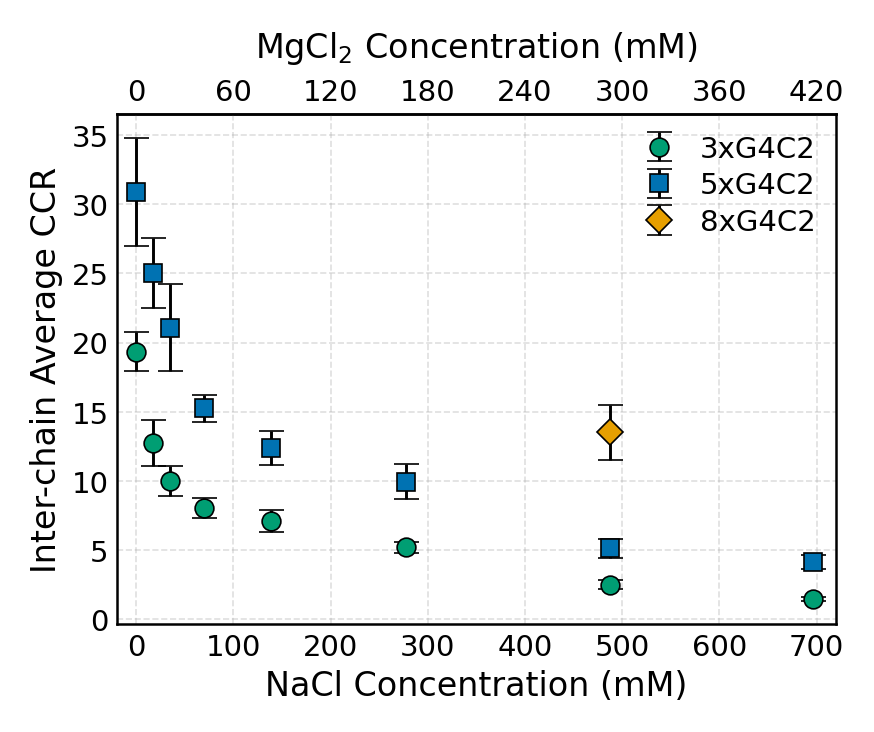

In [9]:
#%%Cell 6: Generate Salt Concentration vs. CCR Plotimport pandas as pd
"""
Plot salt concentration versus average inter-chain CCR,
with dual axes for NaCl and MgCl2 concentrations (converted by factor 0.6).
"""
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

def plot_salt_concentration_vs_ccr():
    nacl_to_mgcl2 = lambda x: x * 0.6 # Conversion factor between NaCl and MgCl2 concentrations
    mgcl2_to_nacl = lambda x: x / 0.6
    try:
        df_3x = pd.read_csv("3xG4C2_ccr_data.csv")
        df_5x = pd.read_csv("5xG4C2_ccr_data.csv") 
        df_8x = pd.read_csv("8xG4C2_ccr_data.csv") if os.path.exists("8xG4C2_ccr_data.csv") else None
        print("Data files loaded successfully.")
    except Exception as e:
        print(f"Critical error loading data: {str(e)}")
        return
    # Configure plot style according to journal requirements
    plt.rcParams.update({
        'font.size': 7,
        'axes.labelsize': 8,
        'xtick.labelsize': 7,
        'ytick.labelsize': 7,
        'font.family': 'DejaVu Sans',
        'figure.dpi': 300,
        'figure.figsize': (3.33, 2.5),  
        'axes.linewidth': 0.6,
        'grid.linewidth': 0.4,
        'lines.linewidth': 1.0,
        'lines.markeredgewidth': 0.6,
        'savefig.dpi': 300,
        'savefig.format': 'png',
        'pdf.fonttype': 42
    })

    fig, ax = plt.subplots()
    systems = {
        '3xG4C2': {'df': df_3x, 'color': '#009E73', 'marker': 'o'},
        '5xG4C2': {'df': df_5x, 'color': '#0072B2', 'marker': 's'},
        '8xG4C2': {'df': df_8x, 'color': '#E69F00', 'marker': 'D'}
    }
    salt_conditions = [
        ("neutral", 0), ("17mMNaCl", 17), ("35mMNaCl", 35),
        ("70mMNaCl", 70), ("139mMNaCl", 139), ("278mMNaCl", 278),
        ("487mMNaCl", 487), ("696mMNaCl", 696)
    ]

    for sys_name, sys_config in systems.items():
        if sys_config['df'] is None:
            continue
            
        x_values = []
        y_means = []
        y_errors = []
        
        # Calculate average CCR for each salt condition (using equilibrated data after 8μs)
        for cond_label, nacl_conc in salt_conditions:
            # Filter data for current condition and time window
            cond_data = sys_config['df'][
                (sys_config['df']['Condition'] == cond_label) &
                (sys_config['df']['Time (µs)'] >= 8)
            ]
            
            if cond_data.empty:
                print(f"No data for {sys_name} @ {cond_label}")
                continue
                
            # Extract pre-calculated global mean and standard deviation
            try:
                # Get pre-computed global mean and SD
                global_mean = cond_data['Global Mean'].iloc[0]
                replica_sd = cond_data['Replica SD'].iloc[0]
            except KeyError:
                print(f"Missing SD data for {sys_name} @ {cond_label}")
                continue
                
            x_values.append(nacl_conc)
            y_means.append(global_mean)
            y_errors.append(replica_sd)
            
            # Debug print
            print(f"{sys_name} | {cond_label}:")
            print(f"  Global Mean = {global_mean:.2f} ± {replica_sd:.2f}")

        # Plot with error bars
        if x_values:
            ax.errorbar(
                x_values, y_means, yerr=y_errors,
                fmt=sys_config['marker'],
                markersize=4.5,
                color=sys_config['color'],
                markerfacecolor=sys_config['color'],
                markeredgecolor='k',
                markeredgewidth=0.4,
                ecolor='k',
                elinewidth=0.7,
                capsize=3,
                capthick=0.7,
                label=sys_name,
                zorder=3
            )

    ax.set_xlabel('NaCl Concentration (mM)', labelpad=2)
    ax.set_ylabel('Inter-chain Average CCR', labelpad=2)
    ax.set_xlim(-20, 720)
    ax.set_xticks(np.arange(0, 701, 100))
    # ax.xaxis.set_minor_locator(MultipleLocator(50))
    ax.tick_params(axis='both', which='both', length=0, pad=2)
    ax2 = ax.secondary_xaxis('top', functions=(nacl_to_mgcl2, mgcl2_to_nacl))
    ax2.set_xlabel('MgCl$_2$ Concentration (mM)', labelpad=5)
    ax2.set_xticks(np.arange(0, 421, 60))
    # ax2.xaxis.set_minor_locator(MultipleLocator(30))
    ax2.tick_params(axis='x', length=0, pad=2)
    ax.grid(True, which='major', linestyle='--', linewidth=0.4, alpha=0.4)
    ax.grid(True, which='minor', linestyle=':', linewidth=0.3, alpha=0.2)
    
    ax.legend(
        frameon=False,
        loc='upper right',
        borderpad=0.2,
        handletextpad=0.4,
        labelspacing=0.3
    )

    plt.subplots_adjust(
        left=0.18,
        # right=0.78,
        bottom=0.16,
        top=0.84
    )

    plt.savefig('FigureS3b.png', dpi=300, bbox_inches='tight')
    plt.show()

# Generate plot
plot_salt_concentration_vs_ccr()

Data files loaded successfully.
3xG4C2 - Mean: 2.50, SD: 0.33
5xG4C2 - Mean: 5.14, SD: 0.67
8xG4C2 - Mean: 13.53, SD: 1.99


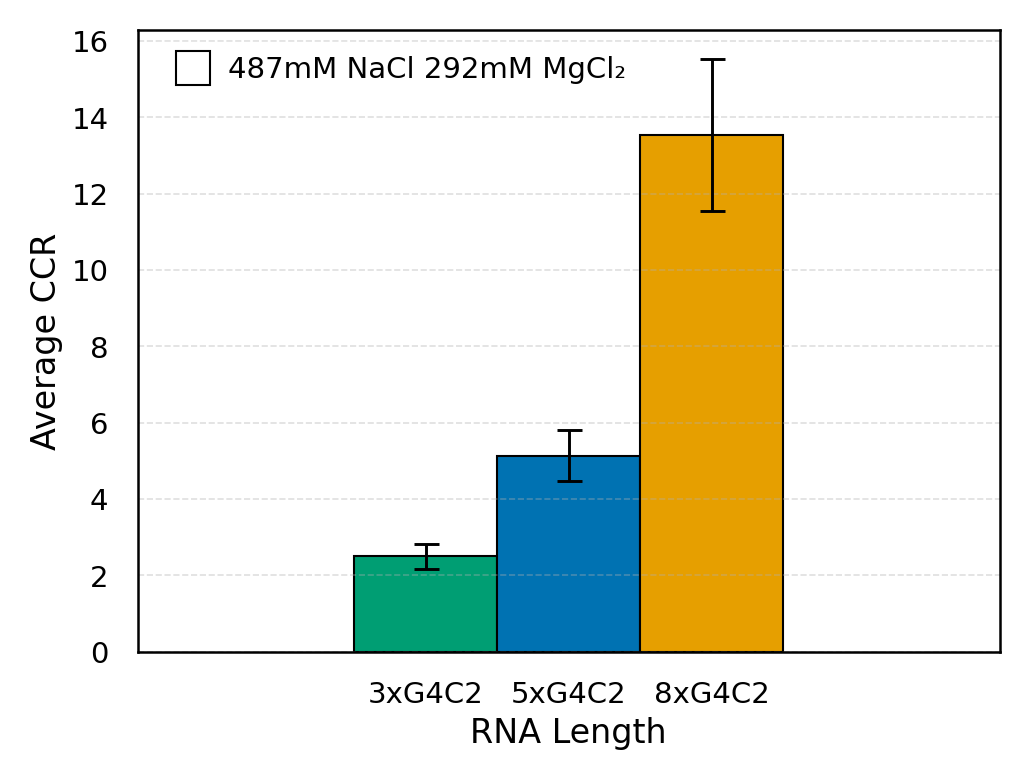

In [11]:
#%% cell 6   Generate Bar Plot for 487mM NaCl Condition
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

def plot_ccr_bar_jpcl():
    """
    Generate bar plot comparing CCR values across different RNA lengths
    at 487mM NaCl (292mM MgCl2) condition.
    """
    try:
        df_3x = pd.read_csv("3xG4C2_ccr_data.csv")
        df_5x = pd.read_csv("5xG4C2_ccr_data.csv")
        df_8x = pd.read_csv("8xG4C2_ccr_data.csv") if os.path.exists("8xG4C2_ccr_data.csv") else None
        print("Data files loaded successfully.")
    except Exception as e:
        print(f"Error loading data files: {e}")
        return
    plt.rcParams.update({
        'font.size': 7,         
        'axes.labelsize': 8,    
        'xtick.labelsize': 7,
        'ytick.labelsize': 7,
        'legend.fontsize': 7,
        'figure.figsize': (3.33, 2.5), 
        'axes.linewidth': 0.6,   
        'grid.linewidth': 0.4,
        'xtick.major.width': 0,  
        'ytick.major.width': 0,
        'savefig.dpi': 300,
        'pdf.fonttype': 42,
        'font.family': 'DejaVu Sans',
        'mathtext.default': 'regular'
    })
    fig, ax = plt.subplots()

    systems = {
        '3xG4C2': df_3x,
        '5xG4C2': df_5x,
        '8xG4C2': df_8x
    }
    colors = ['#009E73', '#0072B2','#E69F00']
    target_condition = '487mMNaCl'

    ccr_values = []
    labels = []
    valid_colors = []
    errors = []     
    for idx, (system, df) in enumerate(systems.items()):
        if df is None:
            print(f"Skipping {system} - no data file")
            continue
        filtered = df[df['Condition'] == target_condition]
        if not filtered.empty:
            global_mean = filtered['Global Mean'].iloc[0]
            sd = filtered['Replica SD'].iloc[0]
            
            ccr_values.append(global_mean)
            errors.append(sd)
            labels.append(system.replace('G4C2', 'G4C2'))
            valid_colors.append(colors[idx])
            
            print(f"{system} - Mean: {global_mean:.2f}, SD: {sd:.2f}")
    bar_width = 0.33  
    spacing = 0     
    x_pos = np.arange(len(labels)) * (bar_width + spacing)  

    ax.bar(x_pos, ccr_values, yerr=errors,
           color=valid_colors, 
           width=bar_width,
           edgecolor='black',
           linewidth=0.5,
           align='edge',         
           error_kw={'elinewidth': 0.7,'capsize': 3,'capthick': 0.7})    

    # leg.get_frame().set_linewidth(0.2)  
    ax.set_xticks(x_pos + bar_width/2)        
    ax.set_xticklabels(systems)#labels

    # ax.set_xticks(x_pos)
    # ax.set_xticklabels(labels)
    ax.set_xlabel('RNA Length', labelpad=2)
    ax.set_ylabel('Average CCR', labelpad=2)
    ax.set_xlim(x_pos[0]-0.5, x_pos[-1]+bar_width+0.5) 

    legend_elements = [
        
    plt.Line2D([0], [0], 
                   marker='s',  
                   color='w',   
                   markerfacecolor='w',
                   markeredgecolor='k',  
                   markersize=8,         
                   markeredgewidth=0.5,  
                   linestyle='None',
                   label='487mM NaCl 292mM MgCl₂')
    ]

    leg = ax.legend(handles=legend_elements,
                   loc='upper left',
                   framealpha=1,        
                   edgecolor='w',      
                   facecolor='white',  
                   handletextpad=0.2, 
                   borderaxespad=0.5,   
                   prop={'size': 7})  

    ax.yaxis.grid(True, linestyle='--', alpha=0.4, linewidth=0.4)

    plt.subplots_adjust(
        left=0.12,    
        right=0.98,   
        bottom=0.16,  
        top=0.92      
    )

    plt.tight_layout(pad=0.5)
    plt.savefig('Figure2d.png', dpi=300, bbox_inches='tight', pad_inches=0.02)
    plt.show()

# Generate the plot
plot_ccr_bar_jpcl()

Data file loaded successfully
3xG4C2 - Normalized mean: 0.0116, Normalized SD: 0.0015
5xG4C2 - Normalized mean: 0.0143, Normalized SD: 0.0019
8xG4C2 - Normalized mean: 0.0235, Normalized SD: 0.0035


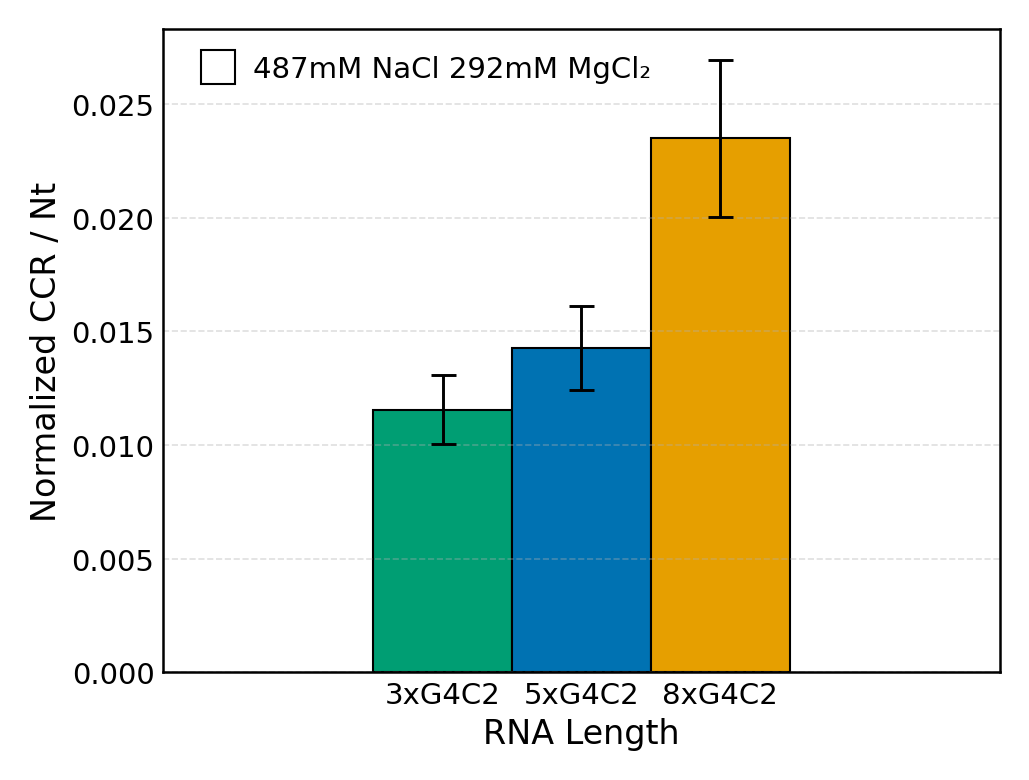

In [13]:
#%% Cell 7: Generate Normalized CCR Bar Plot
"""
Compute normalization factor for inter-chain CCR based on system size.
    
Parameters:
    num_chains (int): Number of RNA chains
    beads_per_chain (int): Number of 'BB' beads per chain
        
Returns:
    float: Normalization factor
"""
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

def compute_inter_chain_normalization(num_chains, beads_per_chain):
    return num_chains * beads_per_chain

def plot_ccr_bar_jpcl():
    """
    Generate bar plot comparing normalized CCR values across different RNA lengths
    at 487mM NaCl (292mM MgCl2) condition.
    """
    systems_params = {
        '3xG4C2': {'num_chains': 12, 'beads_per_chain': 18},
        '5xG4C2': {'num_chains': 12, 'beads_per_chain': 30},
        '8xG4C2': {'num_chains': 12, 'beads_per_chain': 48}
    }
    try:
        df_3x = pd.read_csv("3xG4C2_ccr_data.csv")
        df_5x = pd.read_csv("5xG4C2_ccr_data.csv")
        df_8x = pd.read_csv("8xG4C2_ccr_data.csv") if os.path.exists("8xG4C2_ccr_data.csv") else None
        print("Data file loaded successfully")
    except Exception as e:
        print(f"Error loading data file: {e}")
        return
    plt.rcParams.update({
        'font.size': 7,          
        'axes.labelsize': 8,      
        'xtick.labelsize': 7,
        'ytick.labelsize': 7,
        'legend.fontsize': 7,
        'figure.figsize': (3.33, 2.5),  
        'axes.linewidth': 0.6,    
        'grid.linewidth': 0.4,
        'xtick.major.width': 0,  
        'ytick.major.width': 0,
        'savefig.dpi': 300,
        'pdf.fonttype': 42,
        'font.family': 'DejaVu Sans',
        'mathtext.default': 'regular'
    })
    
    fig, ax = plt.subplots()
    systems = {
        '3xG4C2': df_3x,
        '5xG4C2': df_5x,
        '8xG4C2': df_8x
    }
    colors = ['#009E73', '#0072B2','#E69F00']
    target_condition = '487mMNaCl'

    ccr_values = []
    labels = []
    valid_colors = []
    errors = []    
    for idx, (system, df) in enumerate(systems.items()):
        if df is None:
            print(f"Skipping {system} - no data file")
            continue
        filtered = df[df['Condition'] == target_condition]
        if not filtered.empty:
            # Get the raw data
            global_mean = filtered['Global Mean'].iloc[0]
            sd = filtered['Replica SD'].iloc[0]
            
            # Calculate the normalization fact
            params = systems_params.get(system, {'num_chains': 1, 'beads_per_chain': 1})
            norm_factor = compute_inter_chain_normalization(params['num_chains'], params['beads_per_chain'])
            
            # Perform normalization
            normalized_mean = global_mean / norm_factor
            normalized_sd = sd / norm_factor  # SD normalization method
            
            ccr_values.append(normalized_mean)
            errors.append(normalized_sd)
            labels.append(system.replace('G4C2', 'G4C2'))
            valid_colors.append(colors[idx])
            
            print(f"{system} - Normalized mean: {normalized_mean:.4f}, Normalized SD: {normalized_sd:.4f}")
            
    bar_width = 0.33  
    spacing = 0    
    x_pos = np.arange(len(labels)) * (bar_width + spacing)  

    ax.bar(x_pos, ccr_values, yerr=errors,
           color=valid_colors, 
           width=bar_width,
           edgecolor='black',
           linewidth=0.5,
           align='edge',            
           error_kw={'elinewidth': 0.7,
                     'capsize': 3,
                     'capthick': 0.7})    

    legend_elements = [plt.Line2D([0], [0], 
                   marker='s',  
                   color='w',   
                   markerfacecolor='w',
                   markeredgecolor='k',  
                   markersize=8,         
                   markeredgewidth=0.5,  
                   linestyle='None',
                   label='487mM NaCl 292mM MgCl₂')]
    
    leg = ax.legend(handles=legend_elements,
                   loc='upper left',
                   framealpha=1,          
                   edgecolor='w',         
                   facecolor='white',     
                   handletextpad=0.2,     
                   borderaxespad=0.5,     
                   prop={'size': 7})      
    leg.get_frame().set_linewidth(0.2)
    ax.set_xticks(x_pos + bar_width/2)      
    ax.set_xticklabels(labels)
    ax.set_xlabel('RNA Length', labelpad=2)
    ax.set_ylabel('Normalized CCR / Nt', labelpad=2)
    ax.set_xlim(x_pos[0]-0.5, x_pos[-1]+bar_width+0.5)

    ax.yaxis.grid(True, linestyle='--', alpha=0.4, linewidth=0.4)
    ax.spines[['top', 'right']].set_visible(True)
    ax.tick_params(axis='both', which='both', length=0, pad=2)

    plt.subplots_adjust(
        left=0.12,    
        right=0.98,   
        bottom=0.16,  
        top=0.92      
    )

    plt.tight_layout(pad=0.5)
    plt.savefig('FigureS3a.png', dpi=300, bbox_inches='tight', pad_inches=0.02)

    plt.show()

plot_ccr_bar_jpcl()